In [1]:
import os
import numpy as np
from osgeo import gdal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as py
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import sys
import pandas as pd

import parflow as pf
from parflow.tools.io import read_pfb,write_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

In [6]:
# Directory where PF flow PFBs are saved in
# directory_out = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/averages'
# organized_dir = '/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Organized_Daily_Flow'
directory_out = '/glade/p/univ/ucsm0002/ICOM_danielle/averages'
organized_dir = '/glade/work/tijerina/subsurface_paper/my_validation_scripts/WTD/Organized_WTD'

usgs_data = 'selected_gages_flow_WY2003.csv' #csv of USGS flow from hydrodata

# Where you want to save plots, etc. to
plot_dir = '/glade/work/tijerina/subsurface_paper/my_validation_scripts/WTD/Figures'

# need to change water year and number of days
water_year = 2003
no_days = 364 

In [37]:
### check gage locations for daily flow
well_data = pd.read_csv(f'{organized_dir}/icom_wells.csv')
well_data.head()
# ### set up pandas dataframe of gage ID, lat/long, CONUS2 x and y indices ###
# pf_WTD_df = pd.DataFrame(columns = ['site_id'])
# #pf_flow_df['site_id'] = NWM_gage_csv['id'].astype(int)
# # pf_flow_df['site_name'] = NWM_gage_csv['site_name']
# # pf_flow_df['USGS_lat'] = NWM_gage_csv['lat']
# # pf_flow_df['USGS_lon'] = NWM_gage_csv['lon']
# pf_WTD_df['i_index'] = well_data['i_index']-1
# pf_WTD_df['j_index'] = well_data['j_index']-1

# # # add leading zeros to USGS gages
# # pf_flow_df['site_id'] = pf_flow_df['site_id'].astype('str').str.zfill(8)

# pf_WTD_df

,x,y,obs
0,6,297,40.64
1,7,300,37.22
2,6,302,23.54
3,8,308,43.31
4,6,311,17.33


In [38]:
# set up dataframe with obs and PF WTD
wtd_df = pd.DataFrame(columns = ['obs','PF'])
wtd_df['obs'] = well_data['obs']

In [25]:
### READ WTD PFBs ###
# Read in CONUS2 daily WTD PFBs and save as df
wtd = np.zeros((8678, 365)) 

for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    pf_wtd_pfb = np.squeeze(read_pfb(f'{directory_out}/WTD.2003.daily.{step}.pfb'))
    wtd[:,i] = pf_wtd_pfb[well_data['y'],well_data['x']]
    print(f'reading WTD for day {step}, flow in m^3/h')

reading WTD for day 001, flow in m^3/h
reading WTD for day 002, flow in m^3/h
reading WTD for day 003, flow in m^3/h
reading WTD for day 004, flow in m^3/h
reading WTD for day 005, flow in m^3/h
reading WTD for day 006, flow in m^3/h
reading WTD for day 007, flow in m^3/h
reading WTD for day 008, flow in m^3/h
reading WTD for day 009, flow in m^3/h
reading WTD for day 010, flow in m^3/h
reading WTD for day 011, flow in m^3/h
reading WTD for day 012, flow in m^3/h
reading WTD for day 013, flow in m^3/h
reading WTD for day 014, flow in m^3/h
reading WTD for day 015, flow in m^3/h
reading WTD for day 016, flow in m^3/h
reading WTD for day 017, flow in m^3/h
reading WTD for day 018, flow in m^3/h
reading WTD for day 019, flow in m^3/h
reading WTD for day 020, flow in m^3/h
reading WTD for day 021, flow in m^3/h
reading WTD for day 022, flow in m^3/h
reading WTD for day 023, flow in m^3/h
reading WTD for day 024, flow in m^3/h
reading WTD for day 025, flow in m^3/h
reading WTD for day 026, 

In [34]:
wtd_df['PF'] = np.sum(wtd, axis = 1)/365 # find daily average for the water year
wtd_df

,obs,PF
0,40.64,291.2
1,37.22,291.2
2,23.54,291.2
3,43.31,291.2
4,17.33,291.2
...,...,...
8673,0.61,291.2
8674,2.90,291.2
8675,0.61,291.2
8676,5.49,291.2


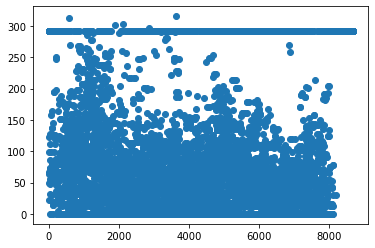

In [36]:
fig, ax = plt.subplots()
ax.scatter(range(8678), wtd_df.PF)
#ax.plot(range(364), pf_flow_matched.loc[1446500])
#ax.legend(['Obs', 'PF'])

In [ ]:
# # SAVE OUT PANDAS DF FOR CONUS2 FLOW
# ### save csv file of all matching gage locations and CONUS2 daily flow, note the USGS STNID's drop the leading zeros when saving
pf_flow_df.to_csv(f'{organized_dir}/ICOM_WTD_{water_year}.csv', sep = ",")

In [ ]:
# indi_file = sys.argv[1]
RUN_NAME = sys.argv[1]
wtd_file = RUN_NAME + '_wtd.npy'
# wtd_file = sys.argv[2]
obs_file = 'icom_wells.csv'
# RUN_NAME = sys.argv[4]
########################

#Read indicator file
# indi_arr = pfio.pfread(indi_file)[:, ::-1, :]

vertical_dis = {4 : 7, 5 : 17, 6 : 42, 7 : 92, 8 : 192, 9: 1192}

indi_to_K = {19:0.005, 20: 0.01, 21:0.02, 22:0.03, 23:0.04, 24:0.05, 25:0.06,
			26:0.08, 27:0.1, 28:0.2}

#Read Shangguan depth dataset
# ds_reg = gdal.Open('shp/Regions.tif')
ds_reg = gdal.Open('icom_mask_final.tif')
geom_reg = ds_reg.GetGeoTransform()
arr_reg = ds_reg.ReadAsArray()

yy0,xx0 = np.where(arr_reg == 1)
# yy0,xx0 = np.where(arr_reg == sel_basin)
new_arr = arr_reg[min(yy0):max(yy0)+1,min(xx0):max(xx0)+1]
len_y, len_x = new_arr.shape
new_len_y = ((len_y//32)+1)*32
n1 = (new_len_y-len_y)//2
n2 = new_len_y-len_y-n1
new_len_x = ((len_x//32)+1)*32
n3 = (new_len_x-len_x)//2
n4 = new_len_x-len_x-n3

# Depth = gdal.Open('extract_results/tmp_shangguan_reprojected.tif').ReadAsArray()           # Used to specify K-set
# sel_depth = Depth[min(yy0)-n1:max(yy0)+n2+1,min(xx0)-n3:max(xx0)+n4+1]

# Read wtd file
wtd_arr = np.load(wtd_file)
sel_mean = np.mean(wtd_arr, axis = 0)

# Read obs file
obs_df = pd.read_csv(obs_file)
obs_xs = np.array(obs_df.x)
obs_ys = np.array(obs_df.y)
obs_wtd = np.array(obs_df.obs)

### Compare with Yin Fan compiled wells
sim_wtds = []
# sim_depths = []
# sim_kis = []

for ii, x in enumerate(obs_xs):
	y = obs_ys[ii]
	obsi = obs_wtd[ii]
	simi = sel_mean[y, x]
	# depthi = sel_depth[y, x]
	# for disi in sorted(vertical_dis.keys()):
	# 	if depthi <= vertical_dis[disi]:
	# 		if indi_arr.shape[0] < 10:
	# 			ki = indi_arr[4, y, x]
	# 		else:
	# 			ki = indi_arr[disi, y, x]
	# 		break
	# """
	# if idi in indi_to_K.keys():
	# 	ki = indi_to_K[idi]
	# else:
	# 	ki = 1
	# """
	i = 0
	while (np.isnan(simi)) and (i < 10):
		ensemble_simi = sel_mean[y - 2: y + 2, x - 2: x + 2].ravel()
		simi = ensemble_simi[i]
		i += 1
	if np.isnan(simi):
		print('error at x: '+str(x))
	sim_wtds.append(simi)
	# sim_kis.append(ki)
	# sim_depths.append(depthi)

obs_wtd = np.array(obs_wtd)
sim_wtds = np.array(sim_wtds)
# sim_kis = np.array(sim_kis)
# sim_depths = np.array(sim_depths)

#%%
### SCATTER PLOT
overall_corr = np.round(np.corrcoef(obs_wtd, sim_wtds)[0,1],2)
wtd_threshold = [0, 10, 20, 30, 40, 50, 100]

fig, axs = plt.subplots(1, 7, figsize = (20, 4))
ax0 = axs[0]
sca0 = ax0.scatter(obs_wtd, sim_wtds, alpha = 0.4, s = 10, 
			# c = sim_kis,
			norm =mpl.colors.LogNorm(1e-3, 1e-1))
# sca0 = ax0.scatter(obs_wtd, sim_wtds, alpha = 0.4, s = 10)
ax0.set_ylim(0, 150)
ax0.set_xlim(0, 150)
ax0.text(70, 105, overall_corr, size = 30)
ax0.set_aspect(1)
ax0.set_title('overall')
ax0.set_ylabel(RUN_NAME, size = 20)
#divider = make_axes_locatable(ax0)
#cax = divider.append_axes('left', size='5%', pad=0.8)
#fig.colorbar(sca0, cax=cax, orientation='vertical')

for i in range(1, 7):
	ax = axs[i]
	sel_points = np.logical_or(np.logical_and(obs_wtd > wtd_threshold[i - 1],
											  obs_wtd <= wtd_threshold[i]),
							   np.logical_and(sim_wtds > wtd_threshold[i - 1],
											  sim_wtds <= wtd_threshold[i]))
	sub_obs = obs_wtd[sel_points]
	sub_wtd = sim_wtds[sel_points]
	sub_corr = np.round(np.corrcoef(sub_obs, sub_wtd)[0,1],2)
	# sub_kis = sim_kis[sel_points]
	ax.set_title('WTD < '+str(wtd_threshold[i]), size = 15)
	ax.scatter(sub_obs, sub_wtd, alpha = 0.4, s = 10, 
			#c = sub_kis,
			norm =mpl.colors.LogNorm(1e-3, 1e-1))
	# ax.scatter(sub_obs, sub_wtd, alpha = 0.4, s = 10)
	y_max = 40 + wtd_threshold[i]
	x_max = 40 + wtd_threshold[i]
	ax.set_ylim(0, y_max)
	ax.set_xlim(0, x_max)
	ax.text(x_max * 0.5, y_max * 0.7, sub_corr, size = 30)
	ax.set_aspect(1)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.1])
fig.colorbar(sca0, cax=cbar_ax, orientation = 'horizontal')
plt.savefig(RUN_NAME+'_scatter.png')

#%%
### Map plot
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
ax0 = axs[0]
im0 = ax0.imshow(sel_mean, cmap = 'RdYlBu',
			norm =mpl.colors.LogNorm(1, 100))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('left', size='5%', pad=0.8)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.set_title('Simulated WTD')

ax1 = axs[1]
sca1 = ax1.scatter(obs_xs, obs_ys, c = (obs_wtd - sim_wtds),
			cmap = 'RdBu_r', s = 6, alpha = 0.6,
			vmin = -4, vmax = 4)
ax1.set_aspect(1)
ax1.invert_yaxis()
ax1.set_title('Observation - Simulation (m)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('left', size='5%', pad=0.8)
fig.colorbar(sca1, cax=cax, orientation='vertical')

plt.savefig(RUN_NAME+'_wtd_map.png')

In [ ]:
#%%
import os
import numpy as np
import gdal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as py
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import sys
import pandas as pd
from pfspinup import pfio

#%%
obs_file = 'icom_wells.csv'
obs_df = pd.read_csv(obs_file)
obs_x = np.array(obs_df.x)
obs_y = np.array(obs_df.y)
obs_value = np.array(obs_df.obs)

#%%
fig, ax = plt.subplots(figsize = (8, 8))
im = ax.scatter(obs_x, obs_y, c = obs_value,
            cmap = 'RdYlBu', s = 6, 
            #alpha = 0.6, 
            norm =mpl.colors.LogNorm(1, 100))
ax.set_aspect(1)
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.8)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.patch.set_facecolor('xkcd:white')
ax.set_title('Observation WTD (m)')

plt.savefig('icom_obs_wtd_map.png')
# %%